# DATA EDA NOTEBOOK 
I use this notebook to understand our data,
and decide how to do cross validation and test set splitting.

In detail: 
I remove users who don't have any tac_flg=1.   
After that, I have 12 users.   

I splitted them to 3 groups (user_tac_group): high_tac, medium_tac, low_tac based on the tac_flg=1 percentage.   
For each group, I choose one user for test set and got 3 of them in total.   

For the remaining 9 users, I uses stratified group kfold to split them such that:   
- one user has to be not in both train and validation. 
- balance the number of record between all type of {user_tac_group}_{tac_flg}. Ex: high_tac_0, high_tac_0, ..., low_tac_1, low_tac_0.  

Finally, I have the list of test user, a set of cross validation that includes which users in train/val for each fold. 

In [3]:
import pandas as pd 
import numpy as np 
import polars as pl
import time
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.cluster import KMeans



In [ ]:
# Define the file paths
file_paths = [
    "../../Preprocess_data/after_preprocess_group1.csv",
    "../../Preprocess_data/after_preprocess_group3.csv",
    "../../Preprocess_data/after_preprocess_group4.csv",
    "../../Preprocess_data/after_preprocess_group5.csv",
    "../../Preprocess_data/after_preprocess_group6.csv"
]

# Load the CSV files into Polars DataFrames
df_final = [pl.read_csv(file_path) for file_path in file_paths]
# get the same columns from all the dataframes
columns = df_final[-1].columns
# Optionally, you can concatenate the DataFrames into a single DataFrame
df_final = pl.concat([data_df[columns] for data_df in df_final])

df_final = df_final.with_columns(
    tac_flg = (df_final['tac (ug/L)']>=35).cast(float)
)

# Create new session_id such that it is unique for all users
df_final = (
    df_final.with_columns([
        pl.concat_str([
            pl.col('user_id').cast(pl.Utf8),
            pl.lit('_'),
            pl.col('session_id')
        ]).alias('combined_key')
    ])
    .with_columns([
        pl.col('combined_key').rank(method='dense').cast(pl.Int32).alias('session_id')
    ])
)

df_final = df_final.drop('combined_key')
df_final = df_final.select([
    'user_id', 'session_id', 'tac_flg', 'tac (ug/L)', 'ZHEARTRATE'
])


In [10]:
with pl.Config(tbl_rows=25):
    tac_status_per_user_df = df_final.group_by('user_id').agg([
        pl.col('tac_flg').sum().alias('tac=1 records'),
        pl.col('tac_flg').count().alias('records_num'),
        pl.col('tac (ug/L)').mean().round(2).alias('tac mean'),
        (pl.col('tac_flg').sum() / pl.col('tac_flg').count() * 100).round(2).alias('tac_flg=1 percentage')
    ]).sort('user_id', descending=False)
    print(tac_status_per_user_df.with_columns([
        pl.col('tac mean').cast(pl.Float64).map_elements(lambda x: f"{x:06.2f}").alias('tac mean'),
        pl.col('tac_flg=1 percentage').cast(pl.Float64).map_elements(lambda x: f"{x:06.2f}").alias('tac_flg=1 percentage')
    ]).sort('tac_flg=1 percentage', descending=True))

shape: (22, 5)
┌─────────┬───────────────┬─────────────┬──────────┬──────────────────────┐
│ user_id ┆ tac=1 records ┆ records_num ┆ tac mean ┆ tac_flg=1 percentage │
│ ---     ┆ ---           ┆ ---         ┆ ---      ┆ ---                  │
│ i64     ┆ f64           ┆ u32         ┆ str      ┆ str                  │
╞═════════╪═══════════════╪═════════════╪══════════╪══════════════════════╡
│ 28      ┆ 3.850001e6    ┆ 4334316     ┆ 105.38   ┆ 088.83               │
│ 16      ┆ 209722.0      ┆ 333993      ┆ 055.68   ┆ 062.79               │
│ 9       ┆ 349307.0      ┆ 794089      ┆ 092.03   ┆ 043.99               │
│ 25      ┆ 213026.0      ┆ 501176      ┆ 076.32   ┆ 042.51               │
│ 24      ┆ 332454.0      ┆ 799421      ┆ 063.87   ┆ 041.59               │
│ 15      ┆ 529897.0      ┆ 1550116     ┆ 039.14   ┆ 034.18               │
│ 6       ┆ 99612.0       ┆ 384322      ┆ 021.42   ┆ 025.92               │
│ 26      ┆ 163220.0      ┆ 752196      ┆ 022.49   ┆ 021.70              

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


<Axes: >

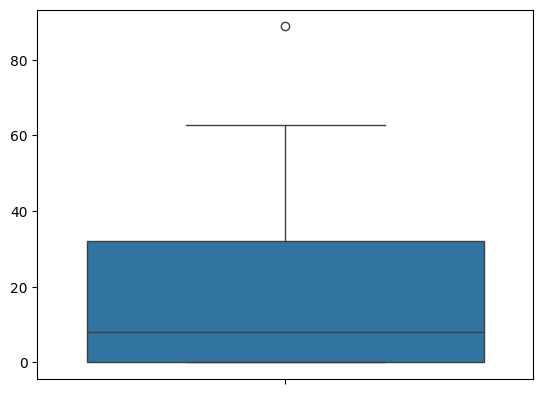

In [11]:
sns.boxplot(tac_status_per_user_df['tac_flg=1 percentage'])

In [12]:
tac_status_per_user_df['tac_flg=1 percentage'].describe()

statistic,value
str,f64
"""count""",22.0
"""null_count""",0.0
"""mean""",18.790909
"""std""",24.529784
"""min""",0.0
"""25%""",0.0
"""50%""",10.28
"""75%""",34.18
"""max""",88.83


We have some user whose tac percentage is 0 (no record for tac_flg=1). We should remove them from the dataset.

In [13]:
tac_status_per_user_df = tac_status_per_user_df.filter(
    tac_status_per_user_df['tac_flg=1 percentage']>0
).sort('tac_flg=1 percentage', descending=True)

In [16]:
tac_status_per_user_df

user_id,tac=1 records,records_num,tac mean,tac_flg=1 percentage
i64,f64,u32,f64,f64
28,3.850001e6,4334316,105.38,88.83
16,209722.0,333993,55.68,62.79
9,349307.0,794089,92.03,43.99
25,213026.0,501176,76.32,42.51
24,332454.0,799421,63.87,41.59
…,…,…,…,…
26,163220.0,752196,22.49,21.7
31,508651.0,2707959,19.1,18.78
10,124805.0,722444,27.57,17.28


now we have 12 users. but the tac_flg=1 percentage is vary. 
I will divide the users into 3 groups based on the tac_flg=1 percentage: high_tac_user, medium_tac_user, low_tac_user


Low Cluster: [25.92 21.7  18.78 17.28 10.28  5.55]
Medium Cluster: [43.99 42.51 41.59 34.18]
High Cluster: [88.83 62.79]


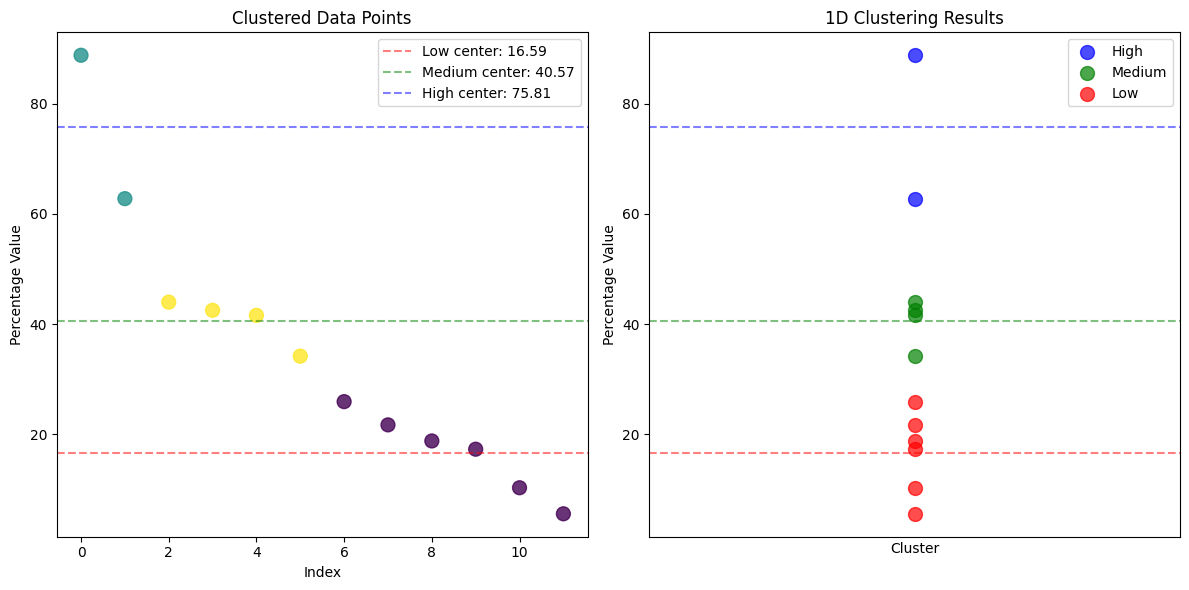

In [17]:
# Input data
data = tac_status_per_user_df['tac_flg=1 percentage'].to_numpy()

# Reshape the data for K-means (needs to be 2D array)
X = data.reshape(-1, 1)

# Apply K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X)

# Get the cluster labels and centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_.flatten()

# Sort the centers to identify high, medium, and low clusters
sorted_idx = np.argsort(centers)
cluster_map = {sorted_idx[0]: 'low_tac_user', sorted_idx[1]: 'medium_tac_user', sorted_idx[2]: 'high_tac_user'}

# Create arrays for each cluster
high_values = data[labels == sorted_idx[2]]
medium_values = data[labels == sorted_idx[1]]
low_values = data[labels == sorted_idx[0]]

print("Low Cluster:", low_values)
print("Medium Cluster:", medium_values)
print("High Cluster:", high_values)

# Visualize the clusters
plt.figure(figsize=(12, 6))

# Plot 1: Scatter plot of values colored by cluster
plt.subplot(1, 2, 1)
plt.scatter(range(len(data)), data, c=labels, cmap='viridis', s=100, alpha=0.8)
plt.axhline(y=centers[sorted_idx[0]], color='red', linestyle='--', alpha=0.5, label=f'Low center: {centers[sorted_idx[0]]:.2f}')
plt.axhline(y=centers[sorted_idx[1]], color='green', linestyle='--', alpha=0.5, label=f'Medium center: {centers[sorted_idx[1]]:.2f}')
plt.axhline(y=centers[sorted_idx[2]], color='blue', linestyle='--', alpha=0.5, label=f'High center: {centers[sorted_idx[2]]:.2f}')
plt.xlabel('Index')
plt.ylabel('Percentage Value')
plt.title('Clustered Data Points')
plt.legend()

# Plot 2: Visualization of all points on a single axis with color coding
plt.subplot(1, 2, 2)
plt.scatter(np.zeros_like(high_values), high_values, c='blue', label='High', s=100, alpha=0.7)
plt.scatter(np.zeros_like(medium_values), medium_values, c='green', label='Medium', s=100, alpha=0.7)
plt.scatter(np.zeros_like(low_values), low_values, c='red', label='Low', s=100, alpha=0.7)
plt.axhline(y=centers[sorted_idx[0]], color='red', linestyle='--', alpha=0.5)
plt.axhline(y=centers[sorted_idx[1]], color='green', linestyle='--', alpha=0.5)
plt.axhline(y=centers[sorted_idx[2]], color='blue', linestyle='--', alpha=0.5)
plt.xlabel('Cluster')
plt.ylabel('Percentage Value')
plt.title('1D Clustering Results')
plt.xticks([])  # Remove x-axis ticks
plt.legend()

plt.tight_layout()
# plt.savefig('clustering_visualization.png')
plt.show()

In [18]:
tac_status_per_user_df =tac_status_per_user_df.with_columns(tac_level_of_user_clusters=labels)
tac_status_per_user_df = tac_status_per_user_df.with_columns(
    tac_level_of_user_clusters=pl.col('tac_level_of_user_clusters').map_elements(
        lambda x: cluster_map.get(x, 'unknown')
    )
)


/tmp/ipykernel_131848/1688219353.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tac_status_per_user_df = tac_status_per_user_df.with_columns(


In [19]:
with pl.Config(tbl_rows=25):
    print(tac_status_per_user_df)

shape: (12, 6)
┌─────────┬───────────────┬─────────────┬──────────┬──────────────────────┬────────────────────────┐
│ user_id ┆ tac=1 records ┆ records_num ┆ tac mean ┆ tac_flg=1 percentage ┆ tac_level_of_user_clus │
│ ---     ┆ ---           ┆ ---         ┆ ---      ┆ ---                  ┆ ters                   │
│ i64     ┆ f64           ┆ u32         ┆ f64      ┆ f64                  ┆ ---                    │
│         ┆               ┆             ┆          ┆                      ┆ str                    │
╞═════════╪═══════════════╪═════════════╪══════════╪══════════════════════╪════════════════════════╡
│ 28      ┆ 3.850001e6    ┆ 4334316     ┆ 105.38   ┆ 88.83                ┆ high_tac_user          │
│ 16      ┆ 209722.0      ┆ 333993      ┆ 55.68    ┆ 62.79                ┆ high_tac_user          │
│ 9       ┆ 349307.0      ┆ 794089      ┆ 92.03    ┆ 43.99                ┆ medium_tac_user        │
│ 25      ┆ 213026.0      ┆ 501176      ┆ 76.32    ┆ 42.51                ┆ 

for each cluster, I will choose as following users for test set 
- high_tac_user (2 users): 16 
- medium tac user (4 users): 25
- low tac user (6 users): 26


In [20]:
user_tac_level_map = dict(zip(tac_status_per_user_df['user_id'], tac_status_per_user_df['tac_level_of_user_clusters']))

In [21]:
test_user_arr = [16,25,26]
accept_user_arr = sorted(set(user_tac_level_map.keys()) - set(test_user_arr))
print('Train/val user list for cross validation:', accept_user_arr)
print('Test user list: ', test_user_arr)

Train/val user list for cross validation: [6, 9, 10, 11, 14, 15, 24, 28, 31]
Test user list:  [16, 25, 26]


In [22]:
df_final = df_final.filter(pl.col('user_id').is_in(accept_user_arr))
df_final = df_final.with_columns(
    tac_level_of_user_clusters=pl.col('user_id').replace_strict( user_tac_level_map)
)
df_final = df_final.with_columns(
    stratified_flag=pl.col('tac_level_of_user_clusters') + pl.col('tac_flg').cast(pl.Utf8)
)


In [23]:
mock_feature = df_final['ZHEARTRATE'].to_numpy()
user_id_arr = df_final['user_id'].to_numpy()
stratified_flag_arr = df_final['stratified_flag'].to_numpy() # user type + tac_flg
tac_flg_arr = df_final['tac_flg'].to_numpy()

In [26]:
fold = 1
for train_idx, test_idx in StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=100).split(mock_feature, stratified_flag_arr, user_id_arr):
    print(f"\n{'='*50}")
    print(f"Fold {fold}")
    print(f"{'='*50}")
    fold += 1
    
    # Basic counts
    train_count = len(train_idx)
    test_count = len(test_idx)
    print(f'Train records: {train_count}')
    print(f'Test records:  {test_count}')
    
    # Get unique stratified flags and their counts
    train_flags, train_flag_counts = np.unique(tac_flg_arr[train_idx], return_counts=True)
    test_flags, test_flag_counts = np.unique(tac_flg_arr[test_idx], return_counts=True)
    
    # Calculate percentages
    train_percentages = (train_flag_counts / train_count) * 100
    test_percentages = (test_flag_counts / test_count) * 100
    
    # Create a DataFrame for better formatting
    print("\nStratified Flag Distribution in Training Set:")
    print("-" * 60)
    train_df = pd.DataFrame({
        'Flag': train_flags,
        'Count': train_flag_counts,
        'Percentage': train_percentages
    })
    # Sort by flag value for consistency
    train_df = train_df.sort_values('Flag')

    print(train_df.to_string(index=False, float_format=lambda x: f"{x:.2f}%"))
    
    print("\nStratified Flag Distribution in Test Set:")
    print("-" * 60)
    test_df = pd.DataFrame({
        'Flag': test_flags,
        'Count': test_flag_counts,
        'Percentage': test_percentages
    })
    # Sort by flag value for consistency
    test_df = test_df.sort_values('Flag')
    print(test_df.to_string(index=False, float_format=lambda x: f"{x:.2f}%"))
    
    # Compare distribution between train and test
    print("\nDistribution Comparison (Test vs Train):")
    print("-" * 60)
    
    # Create a combined dataframe for all flags
    all_flags = np.union1d(train_flags, test_flags)
    comparison_data = []
    
    for flag in all_flags:
        train_count = train_flag_counts[train_flags == flag][0] if flag in train_flags else 0
        test_count = test_flag_counts[test_flags == flag][0] if flag in test_flags else 0
        train_pct = (train_count / train_count) * 100 if train_count > 0 else 0
        test_pct = (test_count / test_count) * 100 if test_count > 0 else 0
        diff_pct = test_pct - train_pct
        
        comparison_data.append({
            'Flag': flag,
            'Train_Count': train_count,
            'Train_Pct': train_pct,
            'Test_Count': test_count,
            'Test_Pct': test_pct,
            'Diff_Pct': diff_pct
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Flag')
    print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.2f}%"))
    
    # User ID information
    train_users = set(user_id_arr[train_idx])
    test_users = set(user_id_arr[test_idx])
    
    print(f"\nUnique Users in Train: {len(train_users)}")
    print(f"Unique Users in Test:  {len(test_users)}")
    print(f"Users in both Train and Test: {len(train_users.intersection(test_users))}")
    
    # Optional: Print first few user IDs for reference
    print(f"\nSample Train User IDs: {list(train_users)}")
    print(f"Sample Test User IDs: {list(test_users)}")


Fold 1
Train records: 18621292
Test records:  1248426

Stratified Flag Distribution in Training Set:
------------------------------------------------------------
 Flag    Count  Percentage
0.00% 12133029      65.16%
1.00%  6488263      34.84%

Stratified Flag Distribution in Test Set:
------------------------------------------------------------
 Flag   Count  Percentage
0.00% 1100814      88.18%
1.00%  147612      11.82%

Distribution Comparison (Test vs Train):
------------------------------------------------------------
 Flag  Train_Count  Train_Pct  Test_Count  Test_Pct  Diff_Pct
0.00%     12133029    100.00%     1100814   100.00%     0.00%
1.00%      6488263    100.00%      147612   100.00%     0.00%

Unique Users in Train: 7
Unique Users in Test:  2
Users in both Train and Test: 0

Sample Train User IDs: [9, 10, 14, 15, 24, 28, 31]
Sample Test User IDs: [11, 6]

Fold 2
Train records: 4678829
Test records:  15190889

Stratified Flag Distribution in Training Set:
------------------

In [ ]:
# Fold 1
# Sample Train User IDs: [9, 10, 14, 15, 24, 28, 31]
# Sample Test User IDs: [11, 6]

# Fold 2
# Sample Train User IDs: [10, 11, 6, 31],
# Sample Test User IDs: [9, 14, 15, 24, 28],

# Fold 3
# Sample Train User IDs: [6, 9, 11, 14, 15, 24, 28]
# Sample Test User IDs: [10, 31]

# Test 
# [16,25,26]

train = [[9, 10, 14, 15, 24, 28, 31],
[10, 11, 6, 31],
[6, 9, 11, 14, 15, 24, 28]]


valid = [[11, 6],
[9, 14, 15, 24, 28],
[10, 31]]

test = [16,25,26]

